In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=''
import tensorflow as tf
import numpy as np
import numpy.random as rng
from data_loader.data_generator import MNISTDataGenerator, LinearDataGenerator
from models.npmodels import NPModel4,DirectNPModel4,AENPModel,AEDFANPModel
from trainers.sf_trainer import SFTrainer, AESFTrainer
from utils.config import process_config
import shutil
import numpy as np
import matplotlib.pyplot as plt

import pickle
import itertools
from utils.utils import tf_matmul_r, tf_matmul_l, tf_eigvecs, tf_eigvals


In [2]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *


In [3]:
inshape=30
hidden=20
outshape=10
batch_size=50
T = rng.randn(outshape, inshape)
def traindata(T, batch_size):
    train_x = rng.randn( batch_size,T.shape[1])
    train_y = np.dot( train_x,T.T)
    return (train_x, train_y)

In [4]:
#p = self.config.state_size[0]
p=30# inshape 
m =20# hiddenshap
j = 10#outshpae
#n = 10
var_xi = 0.1
# learning_rate=0
# lmda_learning_rate=1e-5
#lmda_learning_rate=0

#Training data inputs
x=tf.placeholder(tf.float32,[None,p], name = 'x')
y=tf.placeholder(tf.float32,[None,j], name = 'y')
learning_rate=tf.placeholder(tf.float32,[None],name='learning_rate')
lmda_learning_rate=tf.placeholder(tf.float32,[None],name='lmda_learning_rate')

#Scale weight initialization
alpha0 = np.sqrt(2.0/p)
alpha1 = np.sqrt(2.0/m)
alpha2 = np.sqrt(2.0/j)
alpha3 = 1

A = tf.Variable(rng.randn(p+1,m)*alpha0, name="hidden_weights", dtype=tf.float32)
W = tf.Variable(rng.randn(m+1,j)*alpha1, name="output_weights", dtype=tf.float32)
B = tf.Variable(rng.randn(m+1,j)*alpha2, name="feedback_weights", dtype=tf.float32)

# network architecture with ones added for bias terms
e0 = tf.ones([batch_size, 1], tf.float32)
e1 = tf.ones([batch_size, 1], tf.float32)
x_aug = tf.concat([x, e0], 1)
h = tf.sigmoid(tf.matmul(x_aug, A))
#Make some noise
h_aug = tf.concat([h, e1], 1)
xi = tf.random_normal(shape=tf.shape(h_aug), mean=0.0, stddev=var_xi, dtype=tf.float32)
h_tilde = h_aug + xi
#Add noise to hidden layer
y_p = tf.matmul(h_tilde, W)
y_p_0 = tf.matmul(h_aug, W)

trainable = [A, W, B]


In [5]:
#mean squared error
loss = tf.reduce_sum(tf.pow(y_p-y, 2))/2
loss_0 = tf.reduce_sum(tf.pow(y_p_0-y, 2))/2
e = (y_p - y)
h_prime = tf.multiply(h_tilde, 1-h_tilde)[:,0:m]

#Feedback data for saving
#Only take first item in epoch
delta_bp = tf.matmul(e, tf.transpose(W[0:m,:]))[0,:]
delta_fa = tf.matmul(e, tf.transpose(B[0:m,:]))[0,:]
norm_W = tf.norm(W)
norm_B = tf.norm(B)
error_FA = tf.norm(delta_bp - delta_fa)
alignment = tf.reduce_sum(tf.multiply(delta_fa,delta_bp))/tf.norm(delta_fa)/tf.norm(delta_bp)
norm_diff = tf.norm(W - B)
eigs = tf_eigvals(tf.matmul(tf.transpose(B), W))

#Compute updates for W and A (based on B)
lmda = tf.matmul(e, tf.transpose(B[0:m,:]))
grad_W = tf.gradients(xs=W, ys=loss)[0]
grad_A = tf.matmul(tf.transpose(x_aug), tf.multiply(h_prime, lmda))
grad_B = tf.matmul(tf.matmul(B, tf.transpose(e)) - tf.transpose(xi)*(loss - loss_0)/var_xi, e)

new_W = W.assign(W - learning_rate*grad_W)
new_A = A.assign(A - learning_rate*grad_A)            
new_B = B.assign(B - lmda_learning_rate*grad_B)
train_step = [new_W, new_A, new_B]


# correct_prediction = tf.equal(tf.argmax(y_p, 1), tf.argmax(y, 1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# #Also need to add eigenvector stuff
# training_metrics = [alignment, norm_W, norm_B, error_FA, eigs[0]]

In [8]:
# print(store_err[1,1])
# store_err[np.isnan(store_err)]=0
# plt.imshow(store_err[0], cmap='hot',interpolation='nearest')
with open('Synthdata_nodepert.pkl', 'wb') as f:
    pickle.dump(store_err, f)
    pickle.dump(store_al,f)
    pickle.dump(store_df,f)
    

In [ ]:
init = tf.global_variables_initializer()

eta_1=np.logspace(-3,-4,6)
# eta_1=[0.1,0.1,0.1,0.1,0.1,0.1]
eta_lmda=np.logspace(-5,-6,6)
combo=list(itertools.product(eta_1,eta_lmda))
iteration=2000
store_al=[[] for i in range(len(combo))]
store_df=[[] for i in range(len(combo))]
store_err=[[] for i in range(len(combo))]

with tf.Session() as sess:
    sess.run(init)
    for i in range(len(combo)):
        print("Present combo:",i+1)
        print("Present learning rate index no:",combo[i][0])
        learning_rate1=[combo[i][0]]
        lmda_learning_rate1=[combo[i][1]]
        print("Present lmda learning rate index no:",combo[i][1])  
        for idx in range(iteration):
            (train_x, train_y) = traindata(T, batch_size) 
    
            
            _,align,diff,err=sess.run([train_step,alignment,norm_diff,loss_0],feed_dict={x: train_x, y: train_y,
                                                                                         learning_rate:learning_rate1,
                                                                                         lmda_learning_rate:lmda_learning_rate1})
            store_al[i].append(align)
            store_df[i].append(diff)
            store_err[i].append(err)
            if (idx+1)%500==0:
                print("Iteration count:",idx+1)

        

Present combo: 1
Present learning rate index no: 0.001
Present lmda learning rate index no: 1e-05
Iteration count: 500
Iteration count: 1000
Iteration count: 1500
Iteration count: 2000
Present combo: 2
Present learning rate index no: 0.001
Present lmda learning rate index no: 6.30957344480193e-06
Iteration count: 500
Iteration count: 1000
Iteration count: 1500
Iteration count: 2000
Present combo: 3
Present learning rate index no: 0.001
Present lmda learning rate index no: 3.981071705534969e-06
Iteration count: 500
Iteration count: 1000
Iteration count: 1500
Iteration count: 2000
Present combo: 4
Present learning rate index no: 0.001
Present lmda learning rate index no: 2.5118864315095823e-06
Iteration count: 500


In [115]:
store_err

[[8053.1035,
  6651.6826,
  7567.734,
  6824.0396,
  6351.5264,
  7309.947,
  6589.6055,
  6838.6606,
  7114.701,
  7024.692,
  6651.288,
  6191.691,
  6335.823,
  6619.929,
  7978.3564,
  7054.866,
  5915.0396,
  6232.816,
  6171.8975,
  6106.8906,
  6653.084,
  6408.9756,
  6090.9404,
  6435.822,
  6093.839,
  4980.5493,
  6262.491,
  6351.6924,
  5923.591,
  5760.49,
  5943.415,
  5099.1484,
  4760.6143,
  5239.9287,
  4952.575,
  5718.078,
  5291.7075,
  5141.882,
  5386.614,
  4743.057,
  4634.9004,
  4593.1426,
  5302.7344,
  5322.4023,
  4607.286,
  4548.378,
  3698.8289,
  4084.071,
  5629.683,
  4407.839,
  3696.0461,
  4065.5713,
  4386.933,
  4141.229,
  3964.6816,
  4400.074,
  4264.496,
  4340.704,
  3753.1694,
  3617.6113,
  3444.5059,
  3869.7893,
  3413.6265,
  3269.9102,
  3463.1462,
  3581.667,
  3232.4617,
  2905.1802,
  3151.364,
  3225.8167,
  3349.9668,
  3191.2014,
  3645.3184,
  2935.0908,
  3513.5986,
  3091.4294,
  3002.7031,
  2911.4092,
  3142.6904,
  2662.8

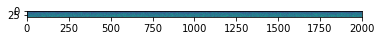

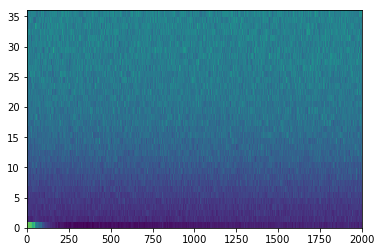

In [116]:
plt.imshow(store_err)
plt.show()
plt.pcolor(store_err)
plt.show()

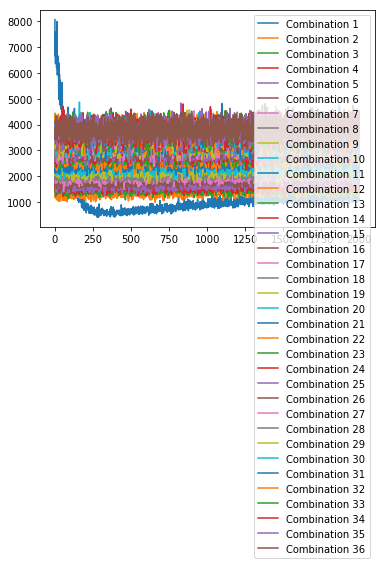

In [117]:
for i in range(len(store_err)):
    leg='Combination '+str(i+1)
    plt.plot(store_err[i],label=leg)
plt.legend()
plt.show()

In [118]:
eta_1

array([0.001     , 0.00063096, 0.00039811, 0.00025119, 0.00015849,
       0.0001    ])